In [254]:
import torch
import matplotlib.pyplot as plt

import test_functions

In [257]:
# mv_gauss=torch.distributions.MultivariateNormal(
#     torch.tensor([2., 2.]), 
#     covariance_matrix=torch.tensor([[1., 0.],[0.,1.]])
#     )
# mv_gauss.sample([3])

In [167]:
import abc

"""
SelectionMethods should take in a list of values and select out pairs
of parents for the next population. For a population size of length m,
they should return m pairs of parents.
"""
class SelectionMethod(abc.ABC):
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def select(self):
        pass

"""
Select pairs of parents randomly from within the top k most 
fit parents.
"""
class TruncationSelection(SelectionMethod):
    def __init__(self, k):
        self.k = k
        super().__init__()

    def select(self, fitnesses):
        _, idx_sorted = torch.sort(fitnesses)
        rands = torch.randint(low=0, high=self.k, size=(len(fitnesses),2))
        return [ torch.tensor([idx_sorted[x[0]].item(),
                               idx_sorted[x[1]].item()]) for x in rands]


"""
Each parent is generated as the fittest member of a group
of k randomly selected individuals.
"""
class TournamentSelection(SelectionMethod):
    def __init__(self, k):
        self.k = k 
        super().__init__()

    def select(self, fitnesses):
        def get_parent():
            competitors_idx = torch.randint(low=0, high=len(fitnesses), size=(self.k,))
            winner_idx = competitors_idx[torch.argmin(fitnesses[competitors_idx])]
            return winner_idx

        pairs = torch.zeros((len(fitnesses),2), dtype=torch.int32)
        for j in range(len(fitnesses)):
            pairs[j, 0] = get_parent()
            pairs[j, 1] = get_parent()

        return pairs

class RouletteWheelSelection(SelectionMethod):
    def __init__(self):
        super().__init__()

    def select(self, fitnesses):
        probs = fitnesses.max() - fitnesses 
        probs = probs / probs.sum() # normalize
        cat=torch.distributions.Categorical(probs=probs)
        print(len(fitnesses))
        return [ cat.sample([2]) for i in range(len(fitnesses)) ]        

In [168]:
# ts = TruncationSelection(2)
# ts = TournamentSelection(2)
ts = RouletteWheelSelection()

fitnesses = torch.tensor([0., 1., 5., 3., 2., 0.])
res=ts.select(fitnesses)

6


In [249]:
import abc

"""
CrossoverMethods should take a pair of parents and combine them
to create a child.
"""
class CrossoverMethod(abc.ABC):
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def crossover(self):
        pass

"""
Crossover two parent chromosomes at a single point, randomly selected
uniformly across the length of the chromosomes.
"""
class SinglePointCrossover(CrossoverMethod):
    def __init__(self):
        super().__init__()

    def crossover(self, a, b):
        crossover_point = torch.randint(0, high=len(a), size=[1])
        return torch.cat([a[:crossover_point], b[crossover_point:]])


"""
Crossover two parent chromosomes between two points, randomly selected
uniformly across the length of the chromosomes.
"""
class TwoPointCrossover(CrossoverMethod):
    def __init__(self):
        super().__init__()

    def crossover(self, a, b):
        crossover_points, _ = torch.sort(torch.randperm(len(a))[:2])
        return torch.cat([a[:crossover_points[0]], 
                          b[crossover_points[0]:crossover_points[1]], 
                          a[crossover_points[1]:]])

"""
Crossover two parent chromosomes by randomly selecting every 
chromosome coordinate from one of the two parents.
"""
class UniformCrossover(CrossoverMethod):
    def __init__(self):
        super().__init__()

    def crossover(self, a, b):
        indic = torch.distributions.Bernoulli(probs=0.5).sample([len(a)])
        return torch.stack([a[i] if indic[i] else b[i] for i in range(len(a))])

In [250]:
# co = SinglePointCrossover()
# co = TwoPointCrossover()
co = UniformCrossover()
a = torch.tensor([1,2,3,4,5])
b = torch.tensor([-1,-2,-3,-4,-5])
res=co.crossover(a, b)

In [261]:
import abc

"""
MutationMethods should take in a single chromosome and make random
modifications to it. This injects randomness into the genetic algorithm
and allows it to search across regions of the search space which were 
not present in the initial population.

These methods are slightly more particular to the structure of the 
chromosomes than the selection method (very general) or the crossover
method, since the allowable values of the coordinates may differ
between applications.
"""
class MutationMethod(abc.ABC):
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def mutate(self):
        pass


"""
GaussianMutation is used for continuous, real-valued design spaces.
It simply adds zero-mean Gaussian noise to the chromosome.

In this simple implementation, we assume a scaled identity covariance.
"""
class GaussianMutation(MutationMethod):
    def __init__(self, scale):
        self.scale = scale
        super().__init__()

    def mutate(self, a):
        return a + torch.randn_like(a) * self.scale

In [424]:
def genetic_algorithm(f, init_population, max_iters, S: SelectionMethod, C: CrossoverMethod, M: MutationMethod, verbose=False):
    # initialize
    population = init_population
    fitnesses = torch.tensor([f(p) for p in population])

    for n_iter in range(max_iters):
        parents = S.select(fitnesses=fitnesses) # pass in the fitnesses

        children = [C.crossover(population[p[0]], population[p[1]]) for p in parents]

        population = [M.mutate(c) for c in children]
        fitnesses = torch.tensor([f(p) for p in population])

        if verbose:
            if (n_iter+1) % 10 == 0:
                print(f"[iteration {n_iter+1:3d}] minimum fitness: {fitnesses.min():.4f}")

    return population

In [411]:
init_population = [torch.tensor([-1., -2.]), torch.tensor([-2., -4.]), torch.tensor([0., 5.]), torch.tensor([1., 1.])]

genetic_algorithm(
    f=test_functions.branin,
    init_population=init_population,
    max_iters=400,
    S=TruncationSelection(3),
    C=UniformCrossover(),
    M=GaussianMutation(0.05),
    verbose=True,
    )

[iteration  10] minimum fitness: 19.7507
[iteration  20] minimum fitness: 19.4310
[iteration  30] minimum fitness: 16.4659
[iteration  40] minimum fitness: 14.4050
[iteration  50] minimum fitness: 13.4067
[iteration  60] minimum fitness: 11.7130
[iteration  70] minimum fitness: 10.6437
[iteration  80] minimum fitness: 7.6014
[iteration  90] minimum fitness: 7.3322
[iteration 100] minimum fitness: 6.2686
[iteration 110] minimum fitness: 5.9388
[iteration 120] minimum fitness: 4.9959
[iteration 130] minimum fitness: 4.3873
[iteration 140] minimum fitness: 4.0194
[iteration 150] minimum fitness: 3.6294
[iteration 160] minimum fitness: 2.7436
[iteration 170] minimum fitness: 1.9749
[iteration 180] minimum fitness: 1.4326
[iteration 190] minimum fitness: 1.0589
[iteration 200] minimum fitness: 0.8011
[iteration 210] minimum fitness: 0.6653
[iteration 220] minimum fitness: 0.4829
[iteration 230] minimum fitness: 0.4018
[iteration 240] minimum fitness: 0.4110
[iteration 250] minimum fitness: 

[tensor([3.0692, 2.2477]),
 tensor([3.0318, 2.2702]),
 tensor([3.1085, 2.4413]),
 tensor([3.0615, 2.2983])]

In [359]:
dim = torch.linspace(-2., 2., 100)
X, Y = torch.meshgrid((dim, dim))

In [370]:
Z = test_functions.rosenbrock([X,Y])

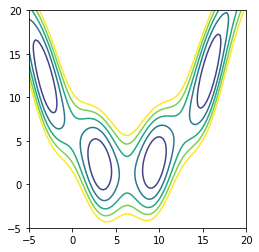

In [383]:
# dim = torch.linspace(-2., 2., 100)
dim = torch.linspace(-5., 20., 100)
X, Y = torch.meshgrid((dim, dim))
Z = test_functions.branin([X,Y])

fig, ax = plt.subplots()
# ax.contour(X,Y,Z, levels=np.arange(0,4,0.2))
ax.contour(X,Y,Z, levels=np.arange(0,48,8))
ax.set_aspect('equal')